In [1]:
from __future__ import print_function
from collections import defaultdict, namedtuple
import fileinput
import sys


In [2]:
def get_sents(lines):
    """
    Args:
        lines (Iterable[str]): the lines

    Yields:
        List[str]: the lines delimited by an empty line
    """
    sent = []
    stripped_lines = (line.strip() for line in lines)
    for line in stripped_lines:
        if line == '':
            yield sent
            sent = []
        else:
            sent.append(line)
    yield sent

In [3]:
Token = namedtuple('Token', 'sent_id word_id word bio tag')
wnut_bio = ('B', 'I', 'O')
wnut_tags = ('corporation', 'creative-work', 'group', 'location', 'person', 'product')


In [4]:
def make_tok(word, bio_tag, sent_id=-1, word_id=-1):
    """
    Args:
        word (str): the surface form of the word
        bio_tag (str): the tag with BIO annotation
        sent_id (int): the sentence ID
        word_id (int): the word ID

    Returns:
        Token

    Raises:
        ValueError
    """
    if bio_tag == 'O':
        bio, tag = 'O', 'O'
    else:
        bio, tag = bio_tag.split('-', 1)
        if bio not in wnut_bio or tag not in wnut_tags:
            raise ValueError('Invalid tag: %s %s %d %d' % (word, bio_tag, sent_id, word_id))
    return Token(sent_id, word_id, word, bio, tag)


def token_to_conll(tok):
    """
    Args:
        tok (Token): 

    Returns:
        str:
    """
    return '%s\t%s' % (tok.word, tok.tag if tok.tag == 'O' else '%s-%s' % (tok.bio, tok.tag))

In [5]:
def line_to_toks(line, sent_id=-1, word_id=-1):
    """
    Args:
        line (str): the input line
        sent_id (int): the current sentence ID
        word_id (int): the current word ID

    Returns:
        Dictionary[str,Token]: the gold and guess tokens stored in a dict with keys for gold and guess

    Raises:
        ValueError
    """
    def make_lbl(i):
        return 'gold' if i == 0 else 'sys_%d' % i

    try:
        fields = line.split('\t')
        word = fields[0]
        return {make_lbl(i): make_tok(word, bio_tag, sent_id, word_id)
                for i, bio_tag in enumerate(fields[1:])}
    except ValueError:
        raise ValueError('Invalid line: %s %d %d' % (line, sent_id, word_id))


def sent_to_toks(sent, sent_id=-1):
    """
    Args:
        sent (Iterator[str]): the lines that comprise a sentence
        sent_id (int): the sentence ID

    Returns:
        Dictionary[str,List[Token]]: the gold and guess tokens for each word in the sentence,
        stored in a dict with keys for gold and guess
    """
    toks = defaultdict(list)
    for word_id, line in enumerate(sent):
        for src, tok in line_to_toks(line, sent_id, word_id).items():
            toks[src].append(tok)
    return toks


In [6]:
Entity = namedtuple('Entity', 'words sent_id word_id_start word_id_stop tag')

In [7]:
def entity_to_tokens(entity):
    """
    Args:
        entity (Entity): 

    Returns:
        List[Token]: 
    """
    def get_bio(_i):
        if entity.tag == 'O':
            return 'O'
        elif _i == 0:
            return 'B'
        else:
            return 'I'

    return [Token(entity.sent_id, entity.word_id_start + i, word, get_bio(i), entity.tag)
            for i, word in enumerate(entity.words)]


In [8]:
def entity_to_conll(entity):
    """
    Args:
        entity (Entity): 

    Returns:
        List[str]: a conll-formatted token tag
    """
    return [token_to_conll(tok) for tok in entity_to_tokens(entity)]


def get_phrases(entities):
    """
    Args:
        entities (Iterable[Entity]): 

    Returns:
        Set[Tuple[str]]
    """
    return {entity.words for entity in entities}

In [39]:
def get_phrases_and_tags(entities):
    """
    Args:
        entities (Iterable[Entity]): 

    Returns:
        Set[Tuple[Tuple[str],str]]:
    """
    return {(entity.words, entity.tag) for entity in entities}


def toks_to_entities(toks):
    """
    Args:
        toks (Iterable[Token]): the tokens in a sentence

    Returns:
        Iterable[Entity]: the corresponding entities in a sentence

    Raises:
        ValueError
    """
    def make_entity(tok):
        return Entity((tok.word, ), tok.sent_id, tok.word_id, tok.word_id+1, tok.tag)

    def extend_entity(entity, tok):
        return Entity(entity.words + (tok.word, ), entity.sent_id, entity.word_id_start, tok.word_id+1, entity.tag)

    def reducer(_entities, tok):
        last = _entities.pop()
        if tok.bio == 'I' and tok.tag == last.tag:
            entity = extend_entity(last, tok)
            _entities.append(entity)
        elif tok.bio == 'B' or (tok.bio == 'O' and tok.tag == 'O'):
            entity = make_entity(tok)
            _entities.extend([last, entity])
        # invalid token sequence tag1 => I-tag2: interpret as tag1 => B-tag2
        elif tok.bio == 'I' and tok.tag != last.tag:
            print('Invalid tag sequence: %s => %s' % (last, tok), file=sys.stderr)
            entity = make_entity(tok)
            _entities.extend([last, entity])
        else:
            raise ValueError('Invalid tag sequence: %s %s' % (last, tok))
        return _entities

    return reduce(reducer, toks[1:], [make_entity(toks[0]), ])


In [10]:
def non_other(entity):
    # type: (Entity) -> bool
    """
    Args:
        entity (Entity): 

    Returns:
        bool
    """
    return entity.tag != 'O'


def filter_entities(entities, p):
    """
    Args:
        entities (Iterable[Entity]): the entities in a sentence
        p (Call[[Entity],bool): the predicate

    Returns:
        List(Entity): the entities filtered by predicate p
    """
    return [entity for entity in entities if p(entity)]


def drop_other_entities(entities):
    """
    Args:
        entities (Iterable[Entity]): 

    Returns:
        Iterator[Entity]
    """
    return filter_entities(entities, non_other)


In [11]:

def doc_to_tokses(lines):
    """
    Args:
        lines (Iterable[str]): the lines in a document

    Returns:
        Dictionary[str,List[List[Tokens]]]: a nested list of list of tokens,
        with one list for each sentence, stored in a dict with keys for gold and guess
    """
    
    sents = get_sents(lines)
    tokses = defaultdict(list)
    for sent_id, sent in enumerate(sents):
        for src, toks in sent_to_toks(sent, sent_id).items():
            tokses[src].append(toks)
    return tokses


def flatten(nested):
    """
    Args:
        nested (Iterable[Iterable[T]]): a nested iterator

    Returns:
        List[T]: the iterator flattened into a list
    """
    return [x for xs in nested for x in xs]


def doc_to_toks(lines):
    """
    Args:
        lines (Iterator[str]): the lines in a document

    Returns:
        Dictionary[str,List[Tokens]]: a lists of all tokens in the document,
        stored in a dict with keys for gold and guess
    """
    return {src: flatten(nested)
            for src, nested in doc_to_tokses(lines).items()}



In [12]:
def doc_to_entitieses(lines):
    """
    Args:
        lines (Iterator[str]): the lines in a document

    Returns:
        Dictionary[str,List[List[Entity]]]: a nested list of lists of entities,
        stored in a dict with keys for gold and guess

    """
    entitieses = defaultdict(list)
    for src, tokses in doc_to_tokses(lines).items():
        entitieses[src] = [toks_to_entities(toks) for toks in tokses]
    return entitieses


def doc_to_entities(lines):
    """
    Args:
        lines (Iterator[str]): the lines in a document

    Returns:
        Dictionary[str,List[Entities]]: a lists of all entities in the document,
        stored in a dict with keys for gold and guess
    """
    return {src: flatten(nested)
            for src, nested in doc_to_entitieses(lines).items()}


def get_tags(entities):
    """
    Args:
        entities (Iterable[Entity]): the entities in a sentence

    Returns:
        Set[str]: a set of their tags, excluding 'O'
    """
    return {entity.tag for entity in entities} - {'O'}




In [13]:
Results = namedtuple('Results', 'gold guess correct p r f')
rem = ('corporation', 'location', 'person')

In [14]:
def get_tagged_entities(entities):
    """
    Args:
        entities (Dict[str,List[Entity]]): 

    Returns:
        Dict[str,List[Entity]]
    """
    return {src: drop_other_entities(entities)
            for src, entities in entities.items()}


def get_correct(gold, guess):
    """
    Args:
        gold (Iterable[T]): 
        guess (Iterable[T]): 

    Returns:
        Set[T]
    """
    return set(gold) & set(guess)


def get_tp(gold, guess):
    """
    Args:
        gold (Iterable[T]): 
        guess (Iterable[T]): 

    Returns:
        Set[T]
    """
    return get_correct(gold, guess)


def get_fn(gold, guess):
    """
    Args:
        gold (Iterable[T]): 
        guess (Iterable[T]): 

    Returns:
        Set[T]
    """
    return set(gold) - set(guess)


def get_fp(gold, guess):
    """
    Args:
        gold (Iterable[T]): 
        guess (Iterable[T]): 

    Returns:
        Set[T]
    """
    return set(guess) - set(gold)


def get_tn(tp, fp, fn, _all):
    """
    Args:
        tp (Set[T]): 
        fp (Set[T]): 
        fn (Set[T]):
        _all (Iterable[T]):

    Returns:
        Set[T]
    """
    return set(_all) - tp - fp - fn


def get_tp_fp_fn_tn(gold, guess, _all):
    """
    Args:
        gold (Iterator[T]): 
        guess (Iterator[T]): 
        _all (Iterator[T]):

    Returns:
        Tuple[Set[str],Set[str],Set[str],Set[str]]:
    """
    tp = get_tp(gold, guess)
    fp = get_fp(gold, guess)
    fn = get_fn(gold, guess)
    tn = get_tn(tp, fp, fn, _all)
    return tp, fp, fn, tn


def get_tp_fp_fn_tn_phrases(gold, guess, _all):
    """
    Args:
        gold: List[Entity]
        guess: List[Entity]
        _all: List[Entity]

    Returns:
        Tuple[Set[str],Set[str],Set[str],Set[str]]:
    """
    all_phrases = get_phrases(_all)
    gold_phrases = get_phrases(gold)
    guess_phrases = get_phrases(guess)
    correct_phrases = get_phrases(get_correct(gold, guess))
    tp = correct_phrases
    fp = guess_phrases - tp
    fn = gold_phrases - tp
    tn = get_tn(tp, fp, fn, all_phrases)
    return tp, fp, fn, tn

In [15]:

def calc_results(gold_entities, guess_entities, surface_form=False):
    """
    Args:
        gold_entities (List[Entity]): the gold standard entity annotations
        guess_entities (List[Entity]): a system's entity guesses
        surface_form (bool): whether or not to calculate f1-scores on the entity surface forms

    Returns:
        Results: the results stored in a namedtuple
    """
    # get the correct system guesses by taking the intersection of gold and guess entities,
    # taking into account tags and document locations
    correct_entities = get_correct(gold_entities, guess_entities)
    if surface_form:  # count only unique surface forms when True
        correct_entities = get_phrases_and_tags(correct_entities)
        gold_entities = get_phrases_and_tags(gold_entities)
        guess_entities = get_phrases_and_tags(guess_entities)

    gold = len(gold_entities)
    guess = len(guess_entities)
    correct = len(correct_entities)

    try:
        p = correct / float(guess)
    except ZeroDivisionError:
        p = 0.0
    try:
        r = correct / float(gold)
    except ZeroDivisionError:
        r = 0.0
    try:
        f = 2.0 * p * r / (p + r)
    except ZeroDivisionError:
        f = 0.0

    return Results(gold, guess, correct, p, r, f)

In [16]:
def fmt_results(tokens, all_entities, surface_form=False):
    """
    Args:
        tokens (Dict[str,List[Tokens]): a dictionary of gold and guess tokens
        all_entities (Dict[str,List[Entity]): a dictionary of gold and guess entities
        surface_form (bool): whether or not to calculate f1-scores on the entity surface forms

    Yield:
        str: (near) W-NUT format evaluation results
    """
    _sys = 'sys_1'
    # throw out 'O' tags to get overall p/r/f
    tagged_entities = get_tagged_entities(all_entities)
    results = {'all': calc_results(all_entities['gold'], all_entities[_sys], surface_form=False),
               'tagged': calc_results(tagged_entities['gold'], tagged_entities[_sys], surface_form),
               'tokens': calc_results(tokens['gold'], tokens[_sys], surface_form=False)}

    yield('processed %d tokens with %d phrases; ' %
          (results['tokens'].gold, results['tagged'].gold))
    yield('found: %d phrases; correct: %d.\n' %
          (results['tagged'].guess, results['tagged'].correct))

    if results['tokens'].gold > 0:
        # only use token counts for accuracy
        yield('accuracy: %6.2f; ' %
              (100. * results['tokens'].correct / results['tokens'].gold))
        yield('precision: %6.2f; ' % (100. * results['tagged'].p))
        yield('recall: %6.2f; ' % (100. * results['tagged'].r))
        yield('FB1: %6.2f\n' % (100. * results['tagged'].f))

    # get results for each entity category
    tags = get_tags(all_entities['gold'])
    #tags.remove('product')
    #tags.remove('creative-work')
    #tags.remove('group')
    
    tags = [v for i, v in enumerate(tags) if v in rem]
    
    print(tags)
    for tag in sorted(tags):
        entities = {src: filter_entities(entities, lambda e: e.tag == tag)
                    for src, entities in all_entities.items()}
        results = calc_results(entities['gold'], entities[_sys], surface_form)
        yield('%17s: ' % tag)
        yield('precision: %6.2f; ' % (100. * results.p))
        yield('recall: %6.2f; ' % (100. * results.r))
        yield('FB1: %6.2f  %d\n' % (100. * results.f, results.correct))


# Training NER - WNUT17 Dataset

In [17]:
import sys, os
# Make sure you put the mitielib folder into the python search path.  There are
# a lot of ways to do this, here we do it programmatically with the following
# two statements:
parent = os.path.dirname(os.path.realpath('__file__'))
sys.path.append(parent + '/MITIE/mitielib')
#print(sys.path)

from mitie import *

In [18]:
### my code ###
words = []
tags = []
with open('data/emerging.dev.conll') as file:

        for line in file:
            s = (line.rstrip('\n')).split('\t')
            if len(s)>1:
                words.append(s[0])
                tags.append(s[1])
                #print(s[1])
#print(type(t))
#print(type(words))
print(len(words))

15733


In [20]:
sample = ner_training_instance(words[0:9999])
s = [] 
for i in range(0,9999):
    #print(tags[i])
    #sample.add_entity(xrange(0,len(words[i])), tags[i])
    #print("%d:%d : %s" % (i,i+1,tags[i]))
    sample.add_entity(xrange(i,i+1), tags[i])
#sample.add_entity(xrange(3,5), "person")
#sample.add_entity(xrange(9,10), "org")




# And we add another training example
#sample2 = ner_training_instance(["The", "other", "day", "at", "work", "I", "saw", "Brian", "Smith", "from", "CMU", "."])
#sample2.add_entity(xrange(7,9), "person")
#sample2.add_entity(xrange(10,11), "org")

In [22]:
trainer = ner_trainer("MITIE/MITIE-models/english/total_word_feature_extractor.dat")
trainer.add(sample)
trainer.num_threads = 4

In [ ]:
ner = trainer.train()
ner.save_to_disk("new_ner_model.dat")

In [ ]:
print ("tags:", ner.get_possible_ner_tags())

In [ ]:
tokens = ["I", "met", "with", "John", "Becker", "at", "HBU", "."]
entities = ner.extract_entities(tokens)
# Happily, it found the correct answers, "John Becker" and "HBU" in this case which we
# print out below.
print ("\nEntities found:", entities)
print ("\nNumber of entities detected:", len(entities))
for e in entities:
    range = e[0]
    tag = e[1]
    entity_text = " ".join(tokens[i] for i in range)
    print ("    " + tag + ": " + entity_text)

## Loading Trained Model and testing on WNut test dataset

In [17]:
import sys, os
# Make sure you put the mitielib folder into the python search path.  There are
# a lot of ways to do this, here we do it programmatically with the following
# two statements:
parent = os.path.dirname(os.path.realpath('__file__'))
sys.path.append(parent + '/MITIE/mitielib')

from mitie import *
from collections import defaultdict
import numpy as np

In [18]:


print("loading MITIE's OWN NER model...")
ner_model = named_entity_extractor('MITIE/MITIE-models/english/ner_model.dat')


loading MITIE's OWN NER model...


#### Wnut - model

In [19]:
print("loading MITIE's WNUT Trained NER model...")
ner_w_model = named_entity_extractor('MITIE/MITIE-models/english/new_ner_model.dat')

print("Tags output by this NER model:", ner_w_model.get_possible_ner_tags())

loading MITIE's WNUT Trained NER model...
Tags output by this NER model: ['O', 'B-location', 'I-location', 'B-person', 'I-person', 'B-corporation', 'I-corporation']


In [20]:
tokens = []
with open('data/emerging.test.conll') as file:
        for line in file:
            s = (line.rstrip('\n')).split('\t')
            if s[0]!='':
                tokens.append(s[0])

#### Extracting Entities MITIE NER 

In [21]:
mitie_entities = ner_model.extract_entities(tokens)

#print("\nEntities found:", entities[0])
print("Number of entities detected by mitie model excluding 'O' :", len(mitie_entities))




Number of entities detected by mitie model excluding 'O' : 655


#### Extracting Entities MITIE WNUT17 NER 

In [22]:
model_w_entities = ner_w_model.extract_entities(tokens)
print("\nNumber of entities detected by mitienut17 model:", len(model_w_entities))



Number of entities detected by mitienut17 model: 22672


In [23]:
with open('w_output.txt', 'w') as the_file:
    for e in model_w_entities:
        range = e[0]
        tag = e[1]
        score = e[2]
        score_text = "{:0.3f}".format(score)
        entity_text = " ".join(tokens[i] for i in range)   
        the_file.write(entity_text+"\t"+tag+"\n")
        #print("   Score: " + score_text + ": " + tag + ": " + entity_text)
        #print("   Score: " + score_text + ": " + tag )


In [24]:
d = []
with open('mitie_output.txt', 'w') as the_file:
    for e in mitie_entities:
        range = e[0]
        tag = e[1]
        score = e[2]
        score_text = "{:0.3f}".format(score)
        entity_text = " ".join(tokens[i] for i in range) 
        #print(len(entity_text.split()))
        if tag == 'ORGANIZATION':
            tag = 'corporation'
        if(len(entity_text.split())>1):
            #print(entity_text)
            for i, val in enumerate(entity_text.split(), 0):
                if(i==0):
                    the_file.write(val+"\t"+('B-'+tag)+"\n")
                else:
                    the_file.write(val+"\t"+('I-'+tag)+"\n")
        else:
            the_file.write(entity_text+"\t"+('B-'+tag)+"\n")
        d.append(entity_text.split())

In [25]:
toks = []
l = [x for x in tokens if x not in d]
for item in tokens:
    if item in d:
        print(item)
        pass
    else:
        toks.append(item)


In [26]:
print(len(toks),len(l))

22672 22672


### Evaluating Results of MITIE Trained NER

In [27]:
with open('data/emerging.test.conll', 'r') as the_file:
    eval_set = the_file.read().splitlines()
print(type(eval_set))

<class 'list'>


In [28]:
with open('w_output.txt', 'r') as the_file:
    w_output = the_file.read().splitlines()
print(type(w_output))
#for x in enumerate(eval_set):
#        eval_set = [j + w_output[] for j in eval_set]

<class 'list'>


In [29]:
with open('mtaner_output', 'r') as the_file:
        nerw_output = the_file.read().splitlines()
with open('test.conll', 'r') as the_file:
        test_conll = the_file.read().splitlines()


t = [i.split('\t')[0] for i in w_output]
t2 = [i.split('\t')[0] for i in nerw_output]
#print(t)
#s = set(t).intersection(t2)

#s = list(s)
#print(s)


In [30]:
#for i,x in enumerate(eval_set):   
#    eval_set = [j + w_output[i] for j in eval_set]
#print(s)
mta_tags_only = []
tags_only = [i.split('\t')[1] for i in w_output]
mta_tags_only = [i.split('\t')[1] for i in nerw_output]


#for i,x in enumerate(nerw_output):
#        mta_tags_only.append(x.split('\t')[1])
        #print(x.split('\t')[1])
    
print(len(test_conll))
print(len(mta_tags_only))
print(len(tags_only))
print(len(eval_set))

23394
23394
22672
22672


### MITIEWNUT17 EVal set

In [31]:
for i,x in enumerate(eval_set): 
    #print(x + '\t'+tags_only[i])
    eval_set[i] = x + '\t'+tags_only[i]
print(len(eval_set))

22672


### MTA17 Eval set

In [32]:
for i,x in enumerate(test_conll): 
    #print(x + '\t'+mta_tags_only[i])
    test_conll[i] = x + '\t'+mta_tags_only[i]
print(len(test_conll))

23394


In [49]:
def wnut_eval(inp):
    # get tokens and entities
    lines = [line for line in inp]
    #print(lines)
    tokens = doc_to_toks(lines)
    entities = doc_to_entities(lines)
    # report results
    print("### ENTITY F1-SCORES ###")
    result = fmt_results(tokens, entities, surface_form=False)
    l = []
    for line in result:
        line = line.replace(';','')
        l.append(line)
        print(line)
        
    labels = ['ss']
    firstR = l[2:5]
    
    labels.append(l[6])
    secondR = l[7:9]
    
    labels.append(l[10])
    tR = l[11:13]
    
    labels.append(l[14])
    fuR = l[15:17]
    
    obj,fig = mis(firstR)
    obj2,fig2 = mis(secondR)
    obj3,fig3 = mis(tR)
    obj4,fig4 = mis(fuR)
    
    objects = [obj,obj2,obj3,obj4]
    figures = [fig,fig2,fig3,fig4]
    
    print()
    print()
    #print(fig)
    return objects,figures,labels
    #for line in k:
        #print(line)
    #for line in fmt_results(tokens, entities, surface_form=False):
        #print(line)

In [59]:
def mis(input):
    res = []
    for i in input:
        res.append(i.split(':'))
    objects = [item[0] for item in res if item[0]!=' ']
    figures = [item[1] for item in res if item[0]!=' ']
    figures = map(float, figures)
    return objects,figures

### Evaluating Results of MITIEWNUT17 

In [128]:
objects,figures,labels = wnut_eval(eval_set)

Invalid tag sequence: Entity(words=('Smith',), sent_id=0, word_id_start=871, word_id_stop=872, tag='person') => Token(sent_id=0, word_id=872, word='Tower', bio='I', tag='location')
Invalid tag sequence: Entity(words=('Europe',), sent_id=0, word_id_start=1056, word_id_stop=1057, tag='location') => Token(sent_id=0, word_id=1057, word='Cheney', bio='I', tag='person')
Invalid tag sequence: Entity(words=('North',), sent_id=0, word_id_start=1987, word_id_stop=1988, tag='O') => Token(sent_id=0, word_id=1988, word='Korea', bio='I', tag='location')
Invalid tag sequence: Entity(words=('chocolate',), sent_id=0, word_id_start=6245, word_id_stop=6246, tag='O') => Token(sent_id=0, word_id=6246, word='frog', bio='I', tag='person')
Invalid tag sequence: Entity(words=('Minas',), sent_id=0, word_id_start=7888, word_id_stop=7889, tag='O') => Token(sent_id=0, word_id=7889, word='Tirith', bio='I', tag='person')
Invalid tag sequence: Entity(words=('kill',), sent_id=0, word_id_start=8246, word_id_stop=8247, 

### ENTITY F1-SCORES ###
processed 22672 tokens with 702 phrases 
found: 306 phrases correct: 183.

accuracy:  96.43 
precision:  59.80 
recall:  26.07 
FB1:  36.31

['person', 'location', 'corporation']
      corporation: 
precision: 100.00 
recall:   1.52 
FB1:   2.99  1

         location: 
precision:  66.67 
recall:  20.00 
FB1:  30.77  30

           person: 
precision:  58.46 
recall:  35.43 
FB1:  44.12  152





Invalid tag sequence: Entity(words=(',',), sent_id=0, word_id_start=9059, word_id_stop=9060, tag='O') => Token(sent_id=0, word_id=9060, word="'", bio='I', tag='product')
Invalid tag sequence: Entity(words=('the',), sent_id=0, word_id_start=9315, word_id_stop=9316, tag='O') => Token(sent_id=0, word_id=9316, word='server', bio='I', tag='product')
Invalid tag sequence: Entity(words=('my',), sent_id=0, word_id_start=9910, word_id_stop=9911, tag='O') => Token(sent_id=0, word_id=9911, word='2', bio='I', tag='product')
Invalid tag sequence: Entity(words=('About',), sent_id=0, word_id_start=10110, word_id_stop=10111, tag='O') => Token(sent_id=0, word_id=10111, word='Hidden', bio='I', tag='product')
Invalid tag sequence: Entity(words=('the',), sent_id=0, word_id_start=10736, word_id_stop=10737, tag='O') => Token(sent_id=0, word_id=10737, word='Hallow', bio='I', tag='product')
Invalid tag sequence: Entity(words=('true',), sent_id=0, word_id_start=10740, word_id_stop=10741, tag='O') => Token(sent

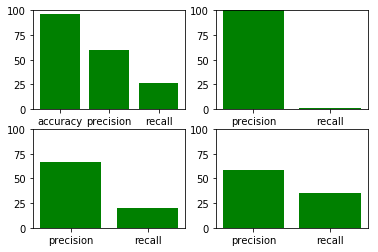

In [127]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=2)
for index, (obj, fig) in enumerate(zip(objects, figures)):
    plt.subplot(2, 2, index+1)
    plt.ylim(0,100)
    plt.bar(obj,fig, label="sdddddddd", color='g')
plt.show()

### Evaluating Results of MITIEWNUT17 

In [125]:
objects,figures,labels = wnut_eval(test_conll)

### ENTITY F1-SCORES ###
processed 23394 tokens with 1079 phrases 
found: 617 phrases correct: 355.

accuracy:  94.18 
precision:  57.54 
recall:  32.90 
FB1:  41.86

['corporation', 'person', 'location']
      corporation: 
precision:  31.91 
recall:  22.73 
FB1:  26.55  15

         location: 
precision:  56.92 
recall:  49.33 
FB1:  52.86  74

           person: 
precision:  70.72 
recall:  50.12 
FB1:  58.66  215





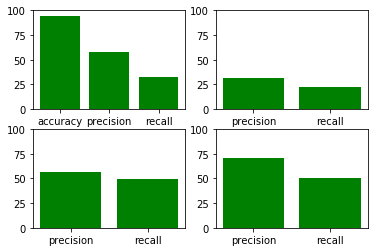

In [124]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for index, (obj, fig) in enumerate(zip(objects, figures)):
    plt.subplot(2, 2, index+1)
    plt.ylim(0,100)
    plt.bar(obj,fig, label="sdddddddd", color='g')
plt.show()
